#Modelling our MBTI Classifier

In [1]:
# installs required for gensim
!pip install gensim
!pip install --upgrade gensim

## standard imports
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

# for loading dataset via google drive
from google.colab import drive
import os

## sklearn imports
# for prepping data
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# countvec & tfidfvec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# classifiers
from sklearn.naive_bayes import BernoulliNB, ComplementNB, CategoricalNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# model metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, accuracy_score

## Loading Data

In [2]:
## mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Change the current working directory
#os.chdir("drive/MyDrive/Capstone data ")
os.chdir("drive/MyDrive/Capstone/data")

In [4]:
# if unzipping needed
#!unzip MBTI_500.zip

In [5]:
mbti = pd.read_csv('MBTI 500.csv')

In [6]:
mbti.shape

(106067, 2)

## Quick Visualistaion of Personality Distribution

In [7]:
# mbti.groupby('type').count()

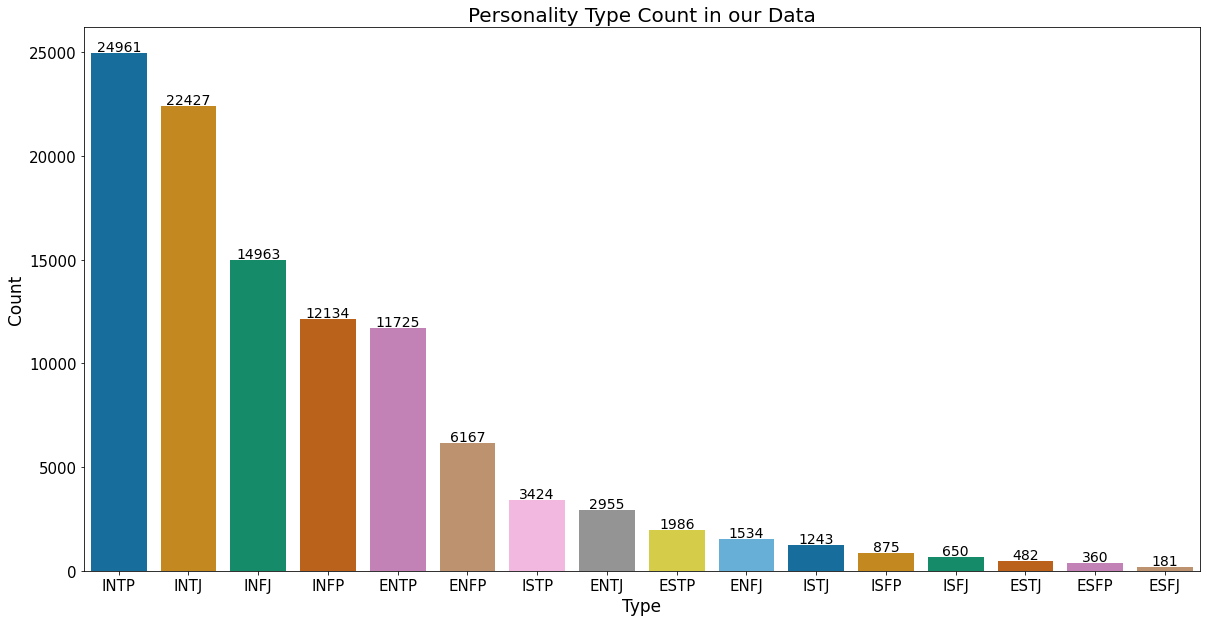

In [8]:
plt.figure(figsize=(20,10))
chart = sns.countplot(x="type", data=mbti, palette = 'colorblind',
              order = mbti['type'].value_counts().index)

for p in chart.patches:
    chart.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=14,
                   xytext = (0, 6), 
                   textcoords = 'offset points')

plt.title('Personality Type Count in our Data',size=20)
plt.xlabel('Type',size=17)
plt.xticks(size=15)
plt.ylabel('Count',size=17)
plt.yticks(size=15)
None

We can see here that the data is extremely skewed and in order for our models to get a good unbiased idea of each personality, we have decided to evenly sample each personality when prepping our data.

## Prepping Data

### Sampling Data

In [9]:
# splitting data to get 180 instances of each personality
types = list(mbti.type.unique())

# creating a dict of dataframes containing each mbti
dfs = dict()
for typ in types:
  dfs[typ] = mbti.loc[mbti.type == typ].iloc[:180]

In [10]:
personalities = list(dfs.keys()) # list of all personalities
del personalities[0] # removing INTJ for when concatinating into one dataframe

In [11]:
mbti_equal = dfs['INTJ']

# concatinating into one dataframe
for personality in personalities:
  mbti_equal = pd.concat([mbti_equal,dfs[personality]])

In [12]:
df = mbti_equal.copy()
df = df[['type','posts']]

#df

### Cleaning Data

In [13]:
def remove_for(string):

    """ Function which removes foreign chars from string """
    
    foreign = re.compile("[" 
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642" 
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", flags=re.UNICODE)
    return foreign.sub(r'', string) # return string without emojis

In [14]:
def token_clean(s):

  """ Removes double spaces and single letters. Then simply tokenizes using split function """
  
  no_space =  re.sub('\s+', ' ',s).strip()    
  tkn_list = no_space.split()
  sc_list=[word for word in tkn_list if len(word) != 1]
  return sc_list

In [15]:
def sentence(l):

  """ Converts list of tokens into sentences """
  
  empty = ''
  for word in l:
    empty = empty +' '+ word
  return empty

In [16]:
df.reset_index(inplace=True)

In [17]:
df['posts'] = df['posts'].apply(remove_for)
df['clean_tkn'] = df.posts.apply(token_clean)
df['sentences'] = df.clean_tkn.apply(sentence)

In [18]:
# creating labels for target values (type of personality)
lbl = LabelEncoder()
df['labels'] = lbl.fit_transform(df.type)

In [19]:
df

,index,type,posts,clean_tkn,sentences,labels
0,0,INTJ,know intj tool use interaction people excuse a...,"[know, intj, tool, use, interaction, people, e...",know intj tool use interaction people excuse ...,10
1,1,INTJ,rap music ehh opp yeah know valid well know fa...,"[rap, music, ehh, opp, yeah, know, valid, well...",rap music ehh opp yeah know valid well know f...,10
2,2,INTJ,preferably p hd low except wew lad video p min...,"[preferably, hd, low, except, wew, lad, video,...",preferably hd low except wew lad video mind g...,10
3,3,INTJ,drink like wish could drink red wine give head...,"[drink, like, wish, could, drink, red, wine, g...",drink like wish could drink red wine give hea...,10
4,4,INTJ,space program ah bad deal meing freelance max ...,"[space, program, ah, bad, deal, meing, freelan...",space program ah bad deal meing freelance max...,10
...,...,...,...,...,...,...
2875,94108,INFP,wonder fuck crap happen lot point idea really ...,"[wonder, fuck, crap, happen, lot, point, idea,...",wonder fuck crap happen lot point idea really...,9
2876,94109,INFP,maybe enfj probably fe dom sjokz isfp deficio ...,"[maybe, enfj, probably, fe, dom, sjokz, isfp, ...",maybe enfj probably fe dom sjokz isfp deficio...,9
2877,94110,INFP,say symptom mine im say infp people sort perso...,"[say, symptom, mine, im, say, infp, people, so...",say symptom mine im say infp people sort pers...,9
2878,94111,INFP,belief word sound like word someone close mind...,"[belief, word, sound, like, word, someone, clo...",belief word sound like word someone close min...,9


## Modelling

### Train Test Split

In [20]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df.posts, df.type):
  train = df.loc[train_index] 
  test = df.loc[test_index] 

In [21]:
# X and y(target values) split for train and test
X_train = train['sentences']
y_train = train['labels']

X_test = test['sentences']
y_test = test['labels']

In [22]:
# classifiers we want to test for
bnb = BernoulliNB()
cnb = ComplementNB()
mnb = MultinomialNB()
rf =  RandomForestClassifier()
lg =  LogisticRegression()

In [23]:
# we've put our models into a list for autmoated training and testing
models = [bnb, cnb, mnb, rf, lg] 

### Count Vectorizer

In [24]:
vect = CountVectorizer()
train_sent_list = train['sentences'].to_list()
train_countvec = vect.fit_transform(train_sent_list)
test_countvec = vect.transform(test['sentences'])

In [25]:
def print_reports(models,train=True):
  """ Prints precision, recall and f1 scores using countvec data using all models"""
  for model in models:
    model.fit(train_countvec, y_train)
    
    if train:
      print('RESULTS FOR TRAINING SET')
      print(model)
      y_predict = model.predict(train_countvec)
      print(classification_report(y_train,y_predict))
      print('\n\n')

    else:
      print('RESULTS FOR TEST SET')
      print(model)
      y_predict = model.predict(test_countvec)
      print(classification_report(y_test,y_predict))
      print('\n\n')
  

#### Train Set

In [26]:
print_reports(models)

RESULTS FOR TRAINING SET
BernoulliNB()
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       144
           1       1.00      1.00      1.00       144
           2       1.00      0.99      1.00       144
           3       1.00      0.99      1.00       144
           4       0.99      1.00      0.99       144
           5       0.99      1.00      0.99       144
           6       0.99      0.91      0.95       144
           7       1.00      0.98      0.99       144
           8       1.00      1.00      1.00       144
           9       1.00      0.99      1.00       144
          10       1.00      1.00      1.00       144
          11       0.99      1.00      1.00       144
          12       0.96      1.00      0.98       144
          13       0.97      1.00      0.99       144
          14       1.00      1.00      1.00       144
          15       0.99      1.00      1.00       144

    accuracy                           0.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### Test Set

In [27]:
print_reports(models, train=False)

RESULTS FOR TEST SET
BernoulliNB()
              precision    recall  f1-score   support

           0       0.69      0.67      0.68        36
           1       0.52      0.61      0.56        36
           2       1.00      0.50      0.67        36
           3       0.81      0.47      0.60        36
           4       0.70      0.86      0.78        36
           5       0.76      0.81      0.78        36
           6       1.00      0.67      0.80        36
           7       1.00      0.81      0.89        36
           8       0.38      0.75      0.50        36
           9       0.38      0.33      0.35        36
          10       0.50      0.44      0.47        36
          11       0.52      0.31      0.39        36
          12       0.48      0.92      0.63        36
          13       0.63      0.67      0.65        36
          14       0.69      0.67      0.68        36
          15       0.74      0.56      0.63        36

    accuracy                           0.63  

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## TF-IDF Vectorizer

In [28]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [29]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)

X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

def tf_idf_reports(models,train=True):
  """ prints precision, recall and f1 scores using tf-idf data """
  for model in models:
    model.fit(X_train_vectors_tfidf, y_train)
    if train:
      print('RESULTS FOR TRAINING SET')
      print(model)
      y_predict = model.predict(X_train_vectors_tfidf)
      print(classification_report(y_train,y_predict))
      print('\n\n')

    else:
      print('RESULTS FOR TEST SET')
      print(model)
      y_predict = model.predict(X_test_vectors_tfidf)
      print(classification_report(y_test,y_predict))
      print('\n\n')


### Train Set

In [30]:
tf_idf_reports(models)

RESULTS FOR TRAINING SET
BernoulliNB()
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       144
           1       1.00      1.00      1.00       144
           2       1.00      0.99      1.00       144
           3       1.00      0.99      1.00       144
           4       0.99      1.00      0.99       144
           5       0.99      1.00      0.99       144
           6       0.99      0.91      0.95       144
           7       1.00      0.98      0.99       144
           8       1.00      1.00      1.00       144
           9       1.00      0.99      1.00       144
          10       1.00      1.00      1.00       144
          11       0.99      1.00      1.00       144
          12       0.96      1.00      0.98       144
          13       0.97      1.00      0.99       144
          14       1.00      1.00      1.00       144
          15       0.99      1.00      1.00       144

    accuracy                           0.

###Test Set

In [31]:
tf_idf_reports(models, train=False)

RESULTS FOR TEST SET
BernoulliNB()
              precision    recall  f1-score   support

           0       0.69      0.67      0.68        36
           1       0.52      0.61      0.56        36
           2       1.00      0.50      0.67        36
           3       0.81      0.47      0.60        36
           4       0.70      0.86      0.78        36
           5       0.76      0.81      0.78        36
           6       1.00      0.67      0.80        36
           7       1.00      0.81      0.89        36
           8       0.38      0.75      0.50        36
           9       0.38      0.33      0.35        36
          10       0.50      0.44      0.47        36
          11       0.52      0.31      0.39        36
          12       0.48      0.92      0.63        36
          13       0.63      0.67      0.65        36
          14       0.69      0.67      0.68        36
          15       0.74      0.56      0.63        36

    accuracy                           0.63  

##Resutls and Conclusion

Generally, we can see that we have extremely high metrics scores on the training sets and noticably lower scores on the test sets. This definitely indicates our model overfitting the data. Despite this we are still achieving good f1 scores of over **70%** in both the count vectorizer and tf-idf methods. Going forward we will attempt to reduce this via regularization, to create a more robust final model. 

We also noted that in the preparation of our data we have cut a large portion of our data to avoid the skewed distribution. This meant we cut out a large portion of valuable data out. We would like to implement oversampling in our future versions to avoid loosing such valuable information.

In summary, there are many optimizations to be still made and a final method the Word2vec method we found during our research into creating meaning from strings for machines that we would like to explore further. Given this was our first NLP project with us being fairly new to it and a given time limit. We are very happy with the base models that we have outputted thus far. 